<a href="https://colab.research.google.com/github/artemk1337/SiameseCGAN-with-embedding-layers-and-contrastive-loss/blob/master/SiameseCGAN_with_embedding_layers_and_contrastive_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing modules

In [32]:
import tensorflow as tf
import tensorflow.keras.backend as K
from keras.layers.merge import concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import layers, Sequential, Model
from tensorflow.keras.layers import (Dense, Conv2D, Conv2DTranspose, Flatten,
                                     MaxPool2D, GlobalAvgPool2D, LeakyReLU, 
                                     Reshape, Input, Embedding, multiply, 
                                     BatchNormalization, GlobalMaxPool2D,
                                     Lambda, Concatenate, Dropout)


import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load data

In [33]:
# image shape
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

# noise vector length
z_dim = 100

## Image normalization
Выгружаем датасет MNIST и нормализуем изображения от 0. до 1.

In [34]:
# load MNIST-dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")


def normalize_img(images):
    """
    Normalizes images: `uint8` -> `float32`.
    """
    return tf.cast(images, tf.float32) / 255.
    # return tf.cast(images, tf.float32) / 127.5 - 1


X_train = normalize_img(X_train)
X_test = normalize_img(X_test)

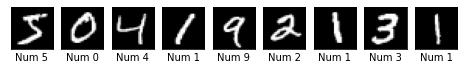

TensorShape([60000, 28, 28])

In [35]:
plt.subplots(figsize=(8, 1)) 
for i in range(9):
    plt.subplot(1, 9, i+1)
    plt.xlabel(f"Num {y_train[i]}")
    plt.imshow(X_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

X_train.shape

# Data processing
Собираем новый датасет, наполовину состоящий из валидных пар изображений и невалидных пар. Валидными пары - картинки с одинаковыми числами, иные - невалидные.

In [36]:
# samples with correct and incorrect image pairs
total_samples = 50000


# dict with each numeric-image index; example: {label: [indexes in array]}
def create_dict_index():
    d = {}
    for i, label in enumerate(y_train):
        if label not in d:
            d[label] = []
        d[label].append(i)
    return d


# create array with random labels
def create_labels(size_: int, prev_labels=None):
    labels = []
    min_ = min(list(label_index_dict.keys()))
    max_ = max(list(label_index_dict.keys()))
    # creating label array
    if prev_labels is None:
        for i in range(size_):
            labels.append(random.randint(min_, max_))
    # creatingarray with different random labels
    else:
        for i in range(size_):
            label = random.randint(min_, max_)
            while label == prev_labels[i]:
                label = random.randint(min_, max_)
            labels.append(label)
    return np.asarray(labels).reshape(-1, 1)


# create new X_train with random numeric-image index from label array
def create_img_array(labels: list, dict_: dict):
    imgs = np.ones(shape=(len(labels), *img_shape))
    for i, label in tqdm(enumerate(labels)):
        idx = dict_[label[0]][random.randint(0, len(dict_[label[0]]) - 1)]
        imgs[i] = np.reshape(X_train[idx], img_shape)
    return imgs


label_index_dict = create_dict_index()

# creating label arrays
labels_true = create_labels(total_samples//2)
labels_false = create_labels(total_samples//2, labels_true)
labels_left = np.concatenate((labels_true, labels_true))
labels_right = np.concatenate((labels_true, labels_false))
print(labels_left.shape, labels_right.shape)

# creating X_train
X_left = create_img_array(labels_left, label_index_dict)
print(X_left.shape)
X_right = create_img_array(labels_right, label_index_dict)
print(X_right.shape)

245it [00:00, 2442.58it/s]

(50000, 1) (50000, 1)


50000it [00:21, 2331.65it/s]
246it [00:00, 2456.32it/s]

(50000, 28, 28, 1)


50000it [00:21, 2318.16it/s]

(50000, 28, 28, 1)


In [37]:
# creating y_train
y_true = np.ones(shape=(total_samples//2, 1))
y_false = np.zeros(shape=(total_samples//2, 1))
y_train = np.concatenate((y_true, y_false))

## Shuffle data
Перемешиваем датасет. Т.к. массивов данных несколько, удобнее всего перемешивать по индексам и сразу конвертировать в `tf.Tensor`.

In [38]:
indices = tf.range(start=0, limit=total_samples, dtype=tf.int32)
idx = tf.random.shuffle(indices)

X_left = tf.gather(X_left, idx)
X_right = tf.gather(X_right, idx)
labels_left = tf.gather(labels_left, idx)
labels_right = tf.gather(labels_right, idx)
y_train = np.array(tf.gather(y_train, idx))

# Build models

## Build generator
Generator получает на вход вектор шума длиной 100 и `label` желаемого числа. Аналогичным способом можно подавать в качестве `label` не только целое число, но и тензор любой размерности. Например, слова, преобразованные с помощью модели `Word2Vec` (в таком случае слой `Embedding` не нужен).  
Кроме того, применив метод обучения без учителя с помощью модели `PCA (principal component analysis)` и одной из моделей кластеризации можно разбить данные на малые выборки. Такая модель дает возможность отличать, например, наклон, шрифт или другие характерные признаки изображения.  
На этом этапе возможно создать новый датасет и увеличить влияние `label` на generator (увеличить вектор признаков), что позволит более точно генерировать желаемые изображения.

In [39]:
def build_generator(img_shape: tuple, z_dim: int):
    # building 2D-model
    model = Sequential()

    model.add(Dense(7*7*512, input_dim=z_dim))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Reshape((7, 7, 512)))
    model.add(Conv2DTranspose(256, 4, strides=2, padding='same'))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(128, 4, strides=2, padding='same'))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # sigmoid activation if    IMAGE / 255
    # tanh activation if       IMAGE / 127.5 - 1
    model.add(Conv2DTranspose(1, channels, strides=1, padding='same',
                              name='IMG_Output', activation='sigmoid'))
    assert model.output.shape[1:] == img_shape,\
      f"Output shape must be {img_shape}, but is {model.layers[-1].shape}"
    return model


# embedding layer allow to generate desired numeric-image
def create_embedding_g(output_dim: int):
    # embedding layers
    label = Input(shape=(1,), dtype='int32', name='Label_Input')
    label_embedding = Embedding(10, output_dim)(label)
    label_embedding = Flatten()(label_embedding)
    return label, label_embedding


def build_generator_embedding(img_shape: tuple):
    # noise input
    z = Input(shape=(z_dim,), name='Noise_Input')

    generator = build_generator(img_shape, z_dim)
    # generator.summary()

    label, label_embedding = create_embedding_g(z_dim)

    # layers merging
    img = generator(multiply([z, label_embedding]))

    # build model
    generator = Model([z, label], img, name='Generator')
    generator.summary()

    return generator

## Build discriminator
Discriminator получает на вход изображение и преобразует его в вектор признаков. Пропустив два разных изображения через модель получим два вектора, которые в дальнейшем нужно сравнить.  
Изначально мы поэлементно рассчитывали модуль разности между двумя векторами, получая новый вектор такого же размера, после чего использовали слой `Dense` с одним выходом и функцией активации `tanh`. В другом случае мы немного пересобрали модель: применили `Lambda`-функцию для рассчета евклидовой дистанции между векторами и убрали слой `Dense`. Сравнив оба метода по скорости обучения GAN-сети и качестве работы generator, мы пришли к выводу, что второй способ гораздо эффективнее первого.  
Как и ожидалось, мы столкнулись с проблемой переобучения `SiameseNet`. Это выражается тем, что модель теряет способность учитывать темные участки изображения и векторизует только светлые участки, из-за чего на сгенерированных картинках появляется лишний шум.

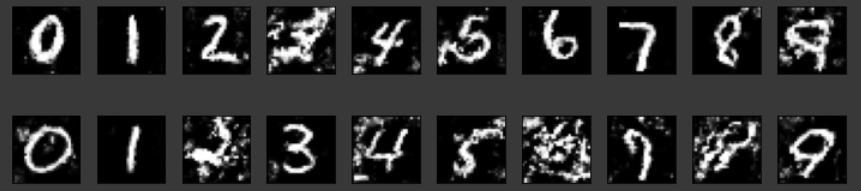  
Была выбвинута идея параллельно с `SiameseNet` обучать модель классификации. Таким способом мы сможем обучить сверточное основание discriminator не только на contrastive loss, рассчитываемой по векторам признаков, но и на бинарной кроссэнтропии как обычный классификатор.  

In [40]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def build_discriminator(img_shape: tuple, output_dim: int, header=True):
    # building 2D-model
    input = Input(shape=(img_shape))

    model = Conv2D(128, 4, strides=2, padding='same')(input)
    #model = BatchNormalization()(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = Dropout(0.2)(model)
    
    model = Conv2D(256, 4, strides=2, padding='same')(model)
    #model = BatchNormalization()(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = Dropout(0.2)(model)
    
    model = Conv2D(512, 4, strides=2, padding='same')(model)
    #model = BatchNormalization()(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = GlobalMaxPool2D()(model)

    if header is True:
        model_vec = Dense(output_dim,
                          activation='tanh',
                          name='Vector_Output')(model)
        model_cl = Dense(128, activation='relu')(model)
        model_cl = Dense(1,
                         activation='sigmoid',
                         name='Classificator_Output')(model_cl)
        return Model(input,  model_vec), Model(input, model_cl)
    else:
        return Model(input, model)
    


def build_discriminator_embedding(img_shape: tuple):
    output_dim = 64
    model_vec, model_cl = build_discriminator(img_shape, output_dim, True)
    # model_discriminator.summary()

    img_d_left = Input(shape=(img_shape), name='Left_Img_Input')
    img_d_right = Input(shape=(img_shape), name='Right_Img_Input')

    output_left = model_vec(img_d_left)
    output_right = model_vec(img_d_right)

    vec_model = Model(img_d_left, output_left, name='Discriminator')

    # version 1 for "binary_crossentropy" loss
    """
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([output_left, output_right])
    prediction = Dense(1, activation='sigmoid')(L1_distance)
    siamese_net = Model([img_d_left, img_d_right],
                        prediction)
    """

    # version 2 for contrastive loss; work perfect
    distance = Lambda(euclidean_distance,output_shape=eucl_dist_output_shape)([output_left, output_right])
    siamese_net = Model([img_d_left, img_d_right],
                        distance)

    siamese_net.summary()
    return siamese_net, vec_model, model_cl

# siamese_net, vec_model, model_cl = build_discriminator_embedding(img_shape)

## Build GAN
Собмраем GAN-сеть. На вход подается вектор шума, `label` и реальное изображение. На выходе евклидова дистанция между векторами.  
В случае с моделью-классификатором на вход подается шум и `label`.

In [41]:
def build_SiameseCGAN(generator, discriminator, z_dim):
    discriminator.trainable = False

    gan_input_dim = Input(shape=(z_dim,), name='Noise_Input')
    gan_input_label = Input(shape=(1,), dtype='int32', name='Label_Input')
    img_real = Input(shape=(img_shape), name='IMG_Input')

    # gan input
    gan_input = [gan_input_dim, img_real, gan_input_label]

    # generator output image
    x = generator([gan_input_dim, gan_input_label])

    # gan output
    gan_output = discriminator([x, img_real])

    # build model
    gan = Model(inputs=gan_input, outputs=gan_output, name='SiameseCGAN')
    gan.summary()
    return gan


def build_ClassifierCGAN(generator, discriminator, z_dim):
    discriminator.trainable = False

    gan_input_dim = Input(shape=(z_dim,), name='Noise_Input')
    gan_input_label = Input(shape=(1,), dtype='int32', name='Label_Input')

    # gan input
    gan_input = [gan_input_dim, gan_input_label]

    # generator output image
    x = generator([gan_input_dim, gan_input_label])

    # gan output
    gan_output = discriminator(x)

    # build model
    gan = Model(inputs=gan_input, outputs=gan_output, name='ClassifierCGAN')
    gan.summary()
    return gan

# Compile models
Создаем и компилируем модели.  
Стоит обратить внимание:
1. Generator не компилируется.
2. Важно сохранять порядок! Сначала компилируем discriminator, а после создаем GAN-сеть.

In [57]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

generator = build_generator_embedding(img_shape)

siamese_net, vec_model, model_d = build_discriminator_embedding(img_shape)

# the larger the batch, the larger the step and the momentum
optimizer = Adam(lr=0.0005, beta_1=0.5)
### For V1 loss: 'binary_crossentropy'
siamese_net.compile(optimizer=optimizer, loss=contrastive_loss, metrics=['binary_accuracy'])

# added to avoid problems with noise on output images
"""
optimizer = Adam(lr=0.0001, beta_1=0.5)
model_d.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
"""

cgan = build_SiameseCGAN(generator, siamese_net, z_dim)

# added to avoid problems with noise on output images
"""
clgan = build_ClassifierCGAN(generator, model_d, z_dim)
"""

# the larger the batch, the larger the step and the momentum
optimizer = Adam(lr=0.0004, beta_1=0.5)
### For V1 loss: 'binary_crossentropy'
cgan.compile(optimizer=optimizer, loss=contrastive_loss, metrics=['binary_accuracy'])

# added to avoid problems with noise on output images
"""
optimizer = Adam(lr=0.0001, beta_1=0.5)
clgan.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
"""

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Label_Input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 100)       1000        Label_Input[0][0]                
__________________________________________________________________________________________________
Noise_Input (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 100)          0           embedding_5[0][0]                
__________________________________________________________________________________________

"\noptimizer = Adam(lr=0.0001, beta_1=0.5)\nclgan.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])\n"

# Fit models

Epoch 1
Processed 10000/50000; [0.19495557248592377]; [0.31515854597091675]


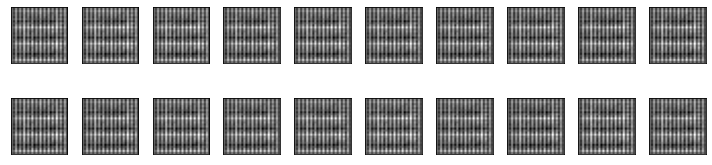

Processed 20000/50000; [0.17813356965780258]; [0.27353614568710327]


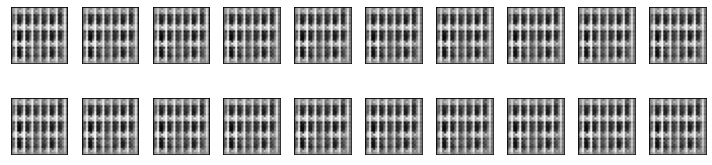

Processed 30000/50000; [0.17536504566669464]; [0.3032644987106323]


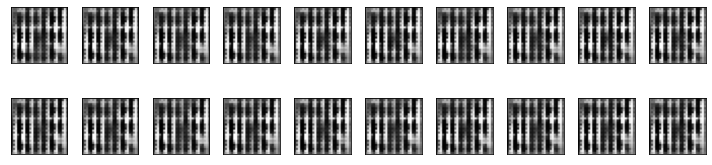

Processed 40000/50000; [0.1825019270181656]; [0.2976924180984497]


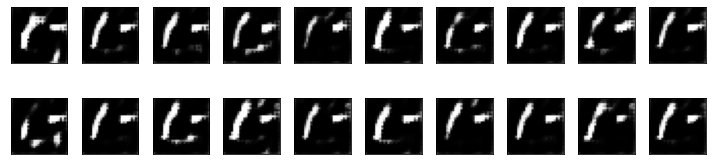

Processed 50000/50000; [0.1579013243317604]; [0.25338223576545715]


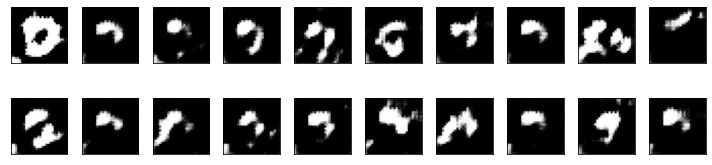

Epoch 2
Processed 10000/50000; [0.18342725187540054]; [0.29034191370010376]


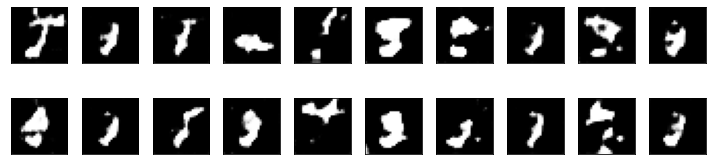

Processed 20000/50000; [0.16134054958820343]; [0.25185614824295044]


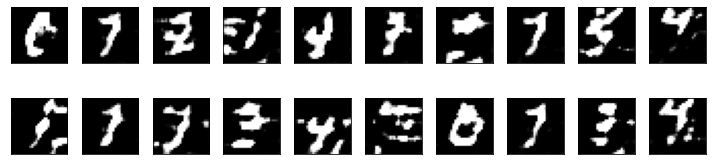

Processed 30000/50000; [0.17589598149061203]; [0.2848815619945526]


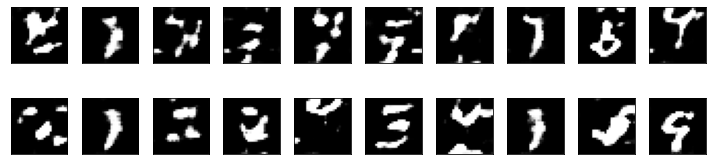

Processed 40000/50000; [0.18346459418535233]; [0.2709648311138153]


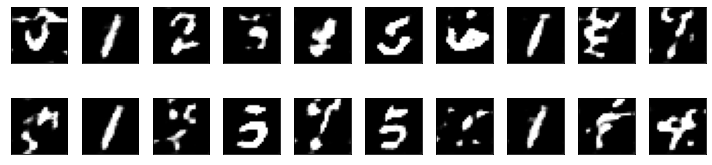

Processed 50000/50000; [0.16134407371282578]; [0.22919519245624542]


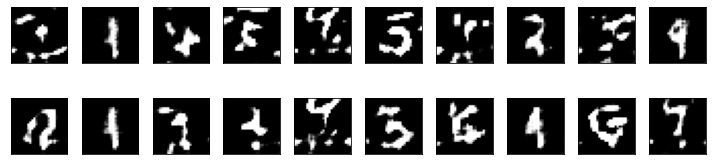

Epoch 3
Processed 10000/50000; [0.18135624378919601]; [0.2641643285751343]


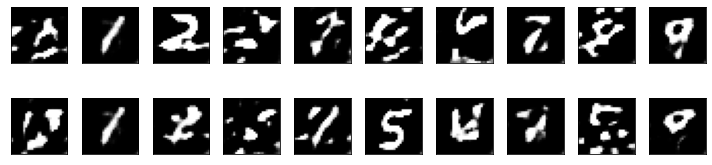

Processed 20000/50000; [0.1615530401468277]; [0.23472419381141663]


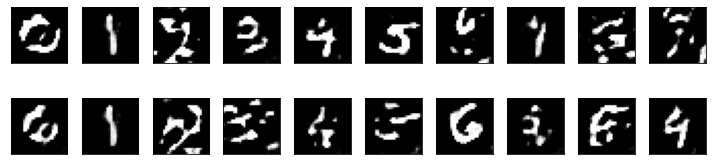

Processed 30000/50000; [0.1817423775792122]; [0.26042354106903076]


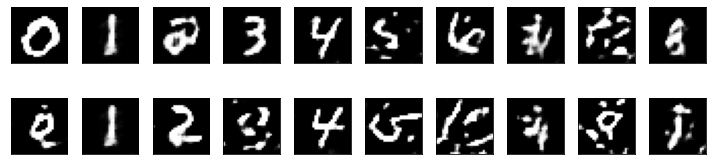

Processed 40000/50000; [0.19176968932151794]; [0.2503986060619354]


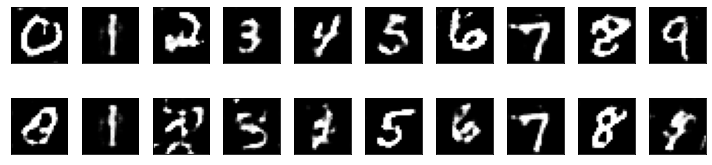

Processed 50000/50000; [0.16748756170272827]; [0.2135525643825531]


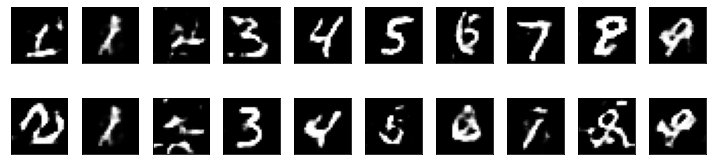

Epoch 4
Processed 10000/50000; [0.19396212697029114]; [0.24768544733524323]


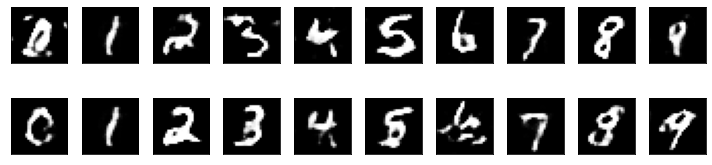

Processed 20000/50000; [0.173506960272789]; [0.2131052166223526]


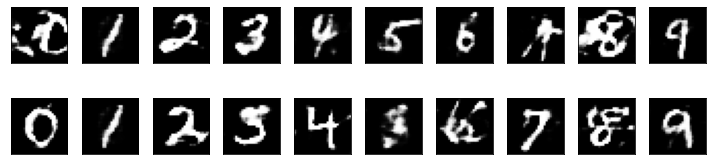

Processed 30000/50000; [0.19051987677812576]; [0.2384352833032608]


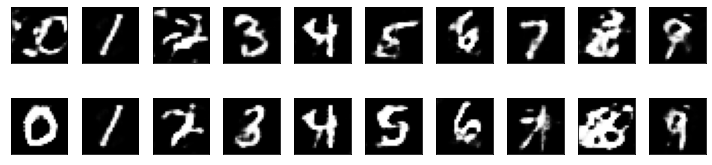

Processed 40000/50000; [0.19848251342773438]; [0.23576076328754425]


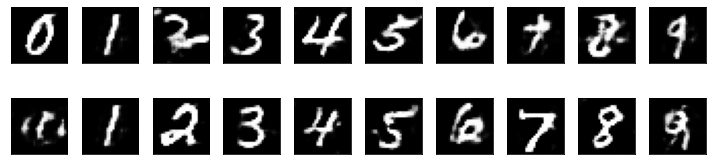

Processed 50000/50000; [0.1686568632721901]; [0.20980305969715118]


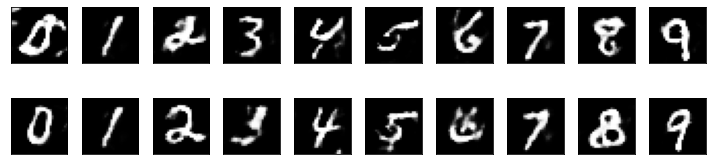

Epoch 5
Processed 10000/50000; [0.19582252949476242]; [0.24861833453178406]


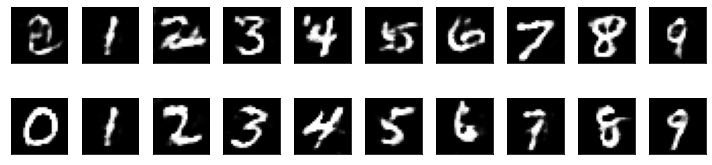

Processed 20000/50000; [0.1746411770582199]; [0.2028104066848755]


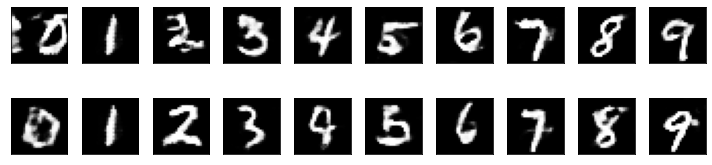

Processed 30000/50000; [0.19196753203868866]; [0.22772952914237976]


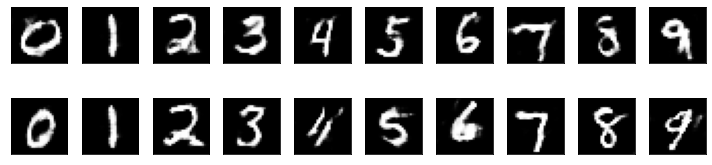

Processed 40000/50000; [0.20124106854200363]; [0.24029569327831268]


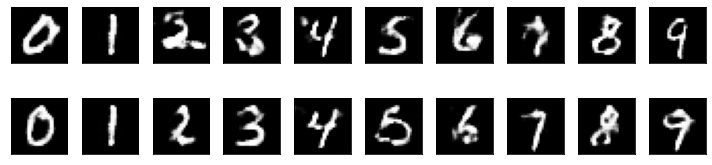

Processed 50000/50000; [0.17431077361106873]; [0.20251132547855377]


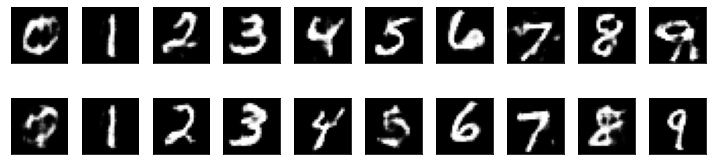

Epoch 6
Processed 10000/50000; [0.19661672413349152]; [0.23716771602630615]


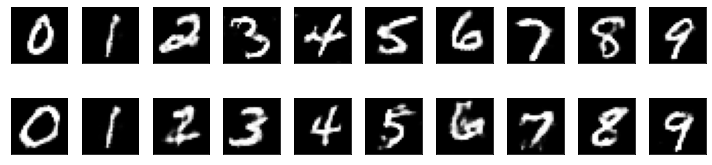

Processed 20000/50000; [0.17535437643527985]; [0.1990363746881485]


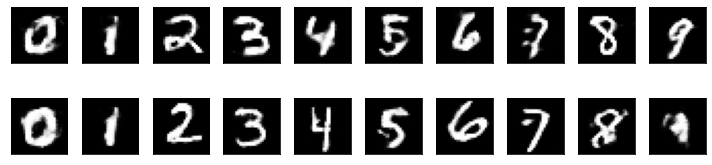

Processed 30000/50000; [0.1901816502213478]; [0.2262582629919052]


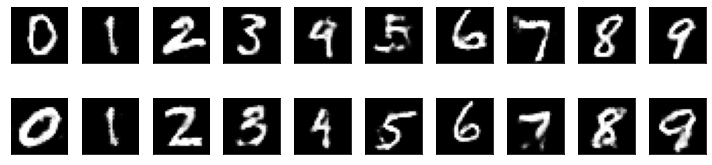

Processed 40000/50000; [0.19881334155797958]; [0.23503437638282776]


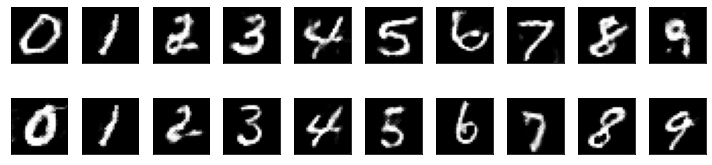

Processed 50000/50000; [0.17249178141355515]; [0.19444486498832703]


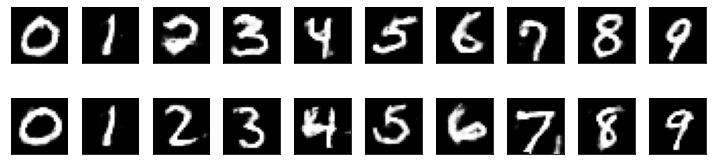

Epoch 7
Processed 10000/50000; [0.19654320925474167]; [0.23492717742919922]


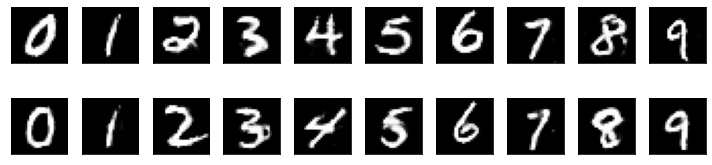

Processed 20000/50000; [0.17769277095794678]; [0.1964184045791626]


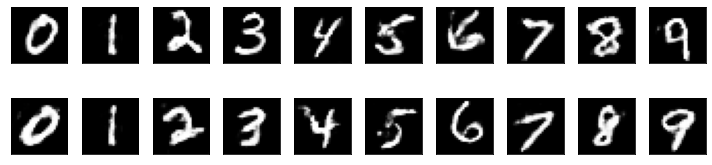

Processed 30000/50000; [0.19044756889343262]; [0.22342219948768616]


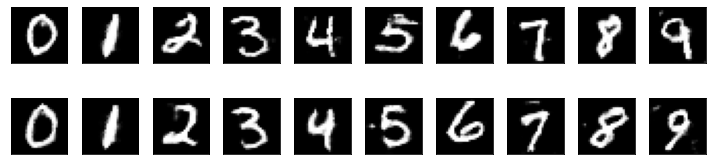

Processed 40000/50000; [0.19483134150505066]; [0.23896247148513794]


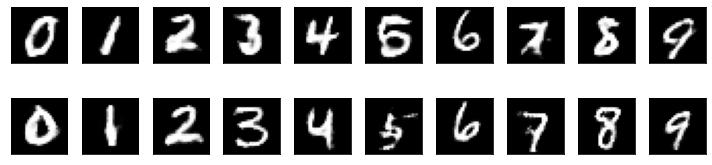

Processed 50000/50000; [0.1708911806344986]; [0.1936156302690506]


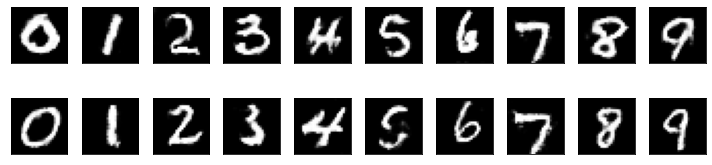

Epoch 8
Processed 10000/50000; [0.19594193249940872]; [0.2251940220594406]


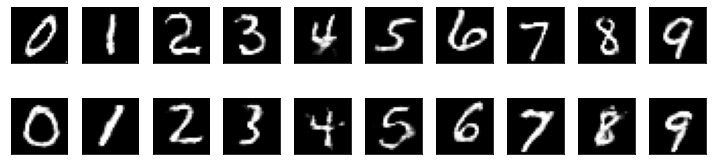

Processed 20000/50000; [0.17554210871458054]; [0.18589504063129425]


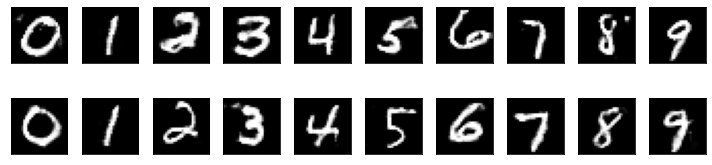

Processed 30000/50000; [0.1915464848279953]; [0.21904031932353973]


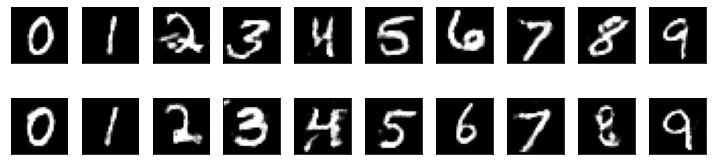

Processed 40000/50000; [0.19739864021539688]; [0.23147113621234894]


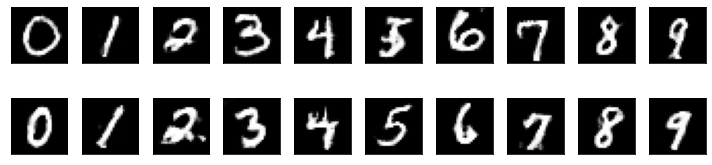

Processed 50000/50000; [0.17187180370092392]; [0.18998223543167114]


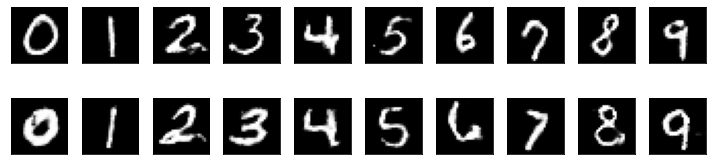

Epoch 9
Processed 10000/50000; [0.1921982392668724]; [0.22915470600128174]


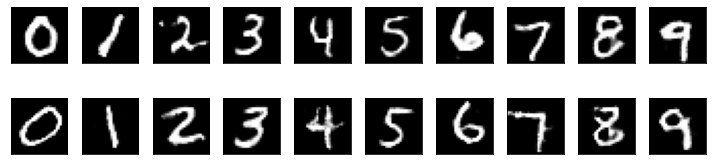

Processed 20000/50000; [0.1764988750219345]; [0.18461009860038757]


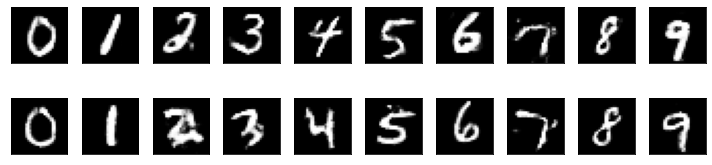

Processed 30000/50000; [0.1947893649339676]; [0.21895557641983032]


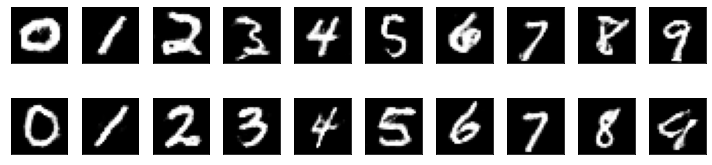

Processed 40000/50000; [0.19529972225427628]; [0.22022780776023865]


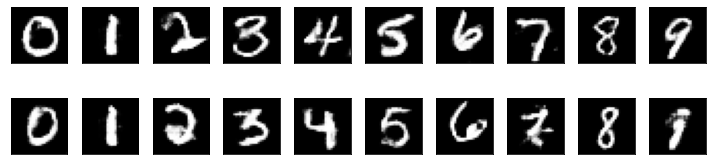

Processed 50000/50000; [0.1703067496418953]; [0.1927882432937622]


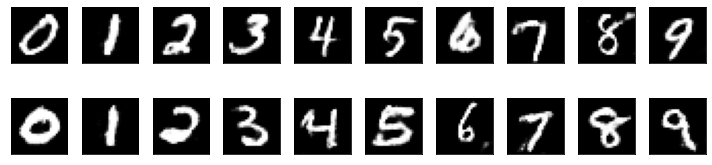

Epoch 10
Processed 10000/50000; [0.19240983575582504]; [0.23489683866500854]


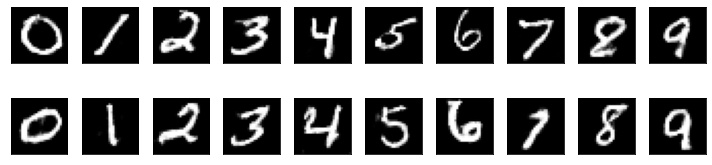

Processed 20000/50000; [0.17301718145608902]; [0.1861516386270523]


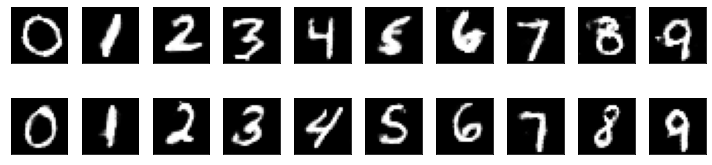

Processed 30000/50000; [0.1875707358121872]; [0.21497929096221924]


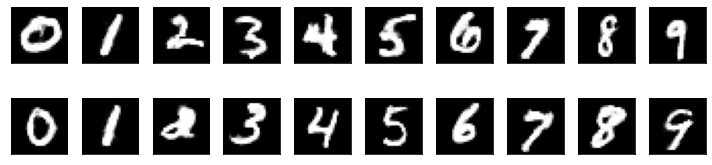

Processed 40000/50000; [0.19510973989963531]; [0.23070794343948364]


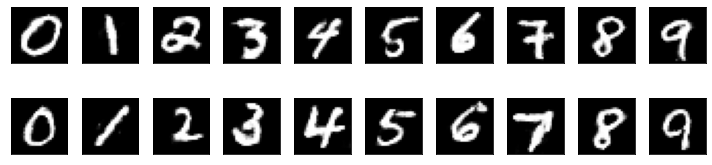

Processed 50000/50000; [0.16793038696050644]; [0.19190654158592224]


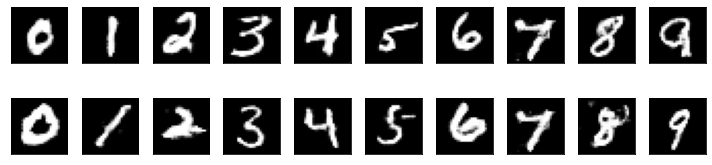

In [58]:
batch_size = 200  # 200
epochs = 10
# margin helps the models fitting better at the start
margin = 0.1

D_LOSS = []
G_LOSS = []


# creating noise-array
def create_noise_array(size_arr):
    return np.random.normal(loc=0, scale=1, size=(size_arr, z_dim))


for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    step = 0
    while (step + 1) * batch_size <= total_samples:

        # training discriminator
        discriminant_loss = 0
        additional_batch = batch_size
        start_index = step*batch_size
        final_index = start_index + additional_batch

        siamese_net.trainable = True
        model_d.trainable = True
        d_loss = siamese_net.train_on_batch(x=[X_left[start_index:final_index],
                                                 X_right[start_index:final_index]],
                                              y=y_train[start_index:final_index])
        discriminant_loss += 0.5 * d_loss[0]

        
        X_fake = generator.predict_on_batch([create_noise_array(additional_batch),
                                             np.random.randint(0, 10, additional_batch).reshape(-1, 1)])
        d_loss = siamese_net.train_on_batch(x=[X_fake,
                                                 X_right[start_index:final_index]],
                                              y=tf.abs(y_true[:additional_batch] - margin))
        discriminant_loss += 0.5 * d_loss[0]
        
        # added to avoid problems with noise on output images
        """
        X_fake = generator.predict_on_batch([create_noise_array(additional_batch),
                                            np.random.randint(0, 10, additional_batch).reshape(-1, 1)])
        d_loss = model_d.train_on_batch(x=tf.concat([X_fake, X_right[start_index:final_index]], 0),
                                        y=tf.abs(np.concatenate((y_false[:additional_batch], y_true[:additional_batch])) - margin))
        """
        D_LOSS += [discriminant_loss]
        
        # training generator
        additional_batch = batch_size
        start_index = step*batch_size
        final_index = start_index + additional_batch

        siamese_net.trainable = False
        model_d.trainable = False
        g_loss = cgan.train_on_batch(x=[create_noise_array(additional_batch),
                                        X_right[start_index:final_index],
                                        labels_left[start_index:final_index]],
                                     y=y_train[start_index:final_index])[0]
        # added to avoid problems with noise on output images
        """
        clgan.train_on_batch(x=[create_noise_array(additional_batch),
                                        labels_left[start_index:final_index]],
                                    y=y_true[:additional_batch])[0]
        """
        G_LOSS += [g_loss]
        step += 1

        if step % 50 == 0:
            print(f"Processed {(step)*batch_size}/{total_samples}; {[discriminant_loss]}; {[g_loss]}")

            samples = 20
            z = np.random.normal(loc=0, scale=1, size=(samples, z_dim))
            labels = np.concatenate((np.arange(0, 10).reshape(-1, 1), np.arange(0, 10).reshape(-1, 1)), axis=0)
            x_fake = generator.predict([z, labels])
            plt.figure(figsize=(10,3))
            for k in range(samples):
                plt.subplot(2, 10, k+1)
                plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
                plt.xticks([])
                plt.yticks([])
            plt.tight_layout()
            # plt.savefig('./' + f'{e}_epoch.png')
            plt.show()


# Evaluate generator and discriminator

In [59]:
img = generator.predict([np.random.normal(loc=0, scale=1, size=(1, z_dim)), np.array([random.randint(0, 9)]).reshape(-1, 1)])
vec_model.predict(img).shape

(1, 64)

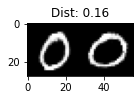

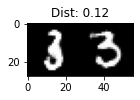

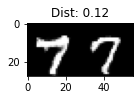

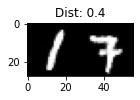

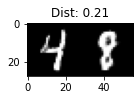

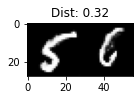

In [60]:
def distance_predicted_img(a:int, b:int, grid_):
    plt.subplots(figsize=(4, 10)) 
    img_a = generator.predict([np.random.normal(loc=0, scale=1, size=(1, z_dim)), np.array([a]).reshape(-1, 1)])
    a = vec_model.predict(img_a)
    img_b = generator.predict([np.random.normal(loc=0, scale=1, size=(1, z_dim)), np.array([b]).reshape(-1, 1)])
    b = vec_model.predict(img_b)

    img_a, img_b = img_a.reshape(28, 28), img_b.reshape(28, 28)
    plt.subplot(grid[grid_, 0:1])
    plt.title(f"Dist: {round(float(tf.norm(a - b)), 2)}")
    plt.imshow(np.concatenate((img_a, img_b), axis=1), cmap='gray')
    plt.show()


grid = plt.GridSpec(6, 2, wspace=0.1, hspace=0.4)

distance_predicted_img(0, 0, 0)
distance_predicted_img(3, 3, 1)
distance_predicted_img(7, 7, 2)

distance_predicted_img(1, 7, 3)
distance_predicted_img(4, 8, 4)
distance_predicted_img(5, 6, 5)

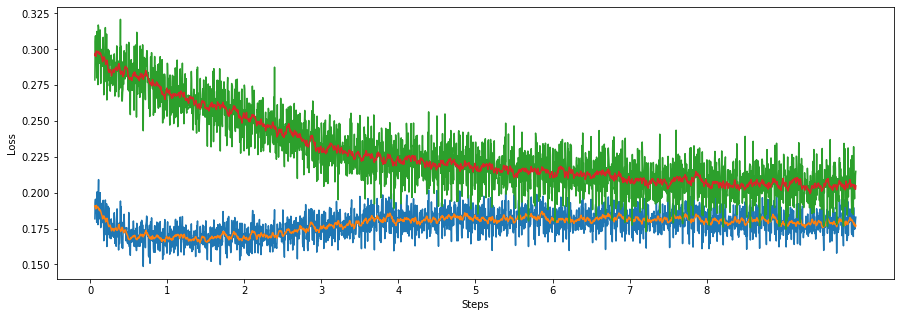

In [61]:
def smooth(y, box_pts=15):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.subplots(figsize=(15, 5))
plt.plot([i for i in range(len(D_LOSS))][15:-15], D_LOSS[15:-15])
plt.plot([i for i in range(len(D_LOSS))][15:-15], smooth(D_LOSS)[15:-15])
plt.plot([i for i in range(len(G_LOSS))][15:-15], G_LOSS[15:-15])
plt.plot([i for i in range(len(G_LOSS))][15:-15], smooth(G_LOSS)[15:-15])
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.xticks([i*(total_samples // batch_size) for i in range(epoch)], [i for i in range(epoch)])
plt.show()

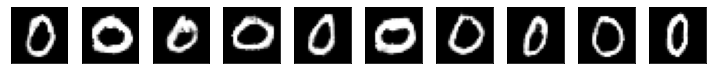

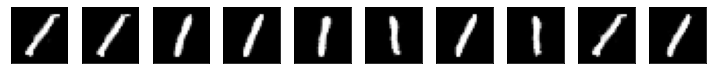

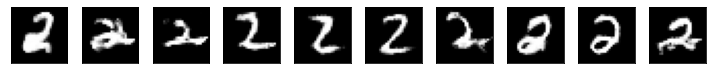

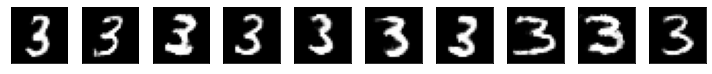

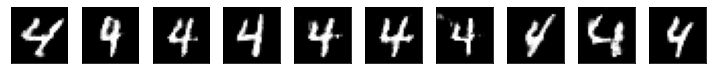

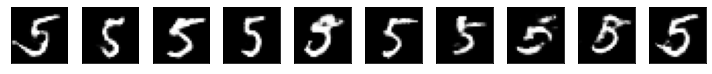

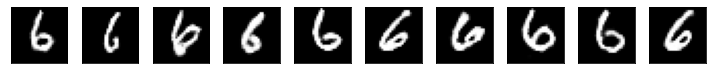

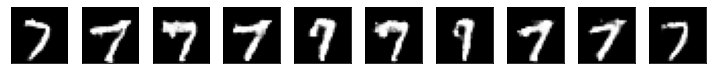

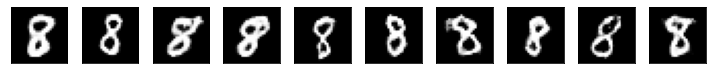

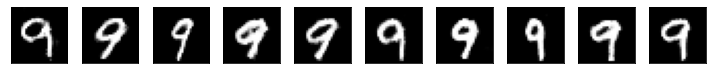

In [62]:
samples = 10
z = np.random.normal(loc=0, scale=1, size=(samples, z_dim))
for i in range(samples):
    labels = np.zeros((samples, 1)) + i
    x_fake = generator.predict([z, labels])
    plt.figure(figsize=(10,2))
    for k in range(samples):
        plt.subplot(1, 10, k+1)
        plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    # plt.savefig('./' + f'{e}_epoch.png')
    plt.show()